In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
import pmdarima as pm
from typing import List

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('14/2/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('01/12/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

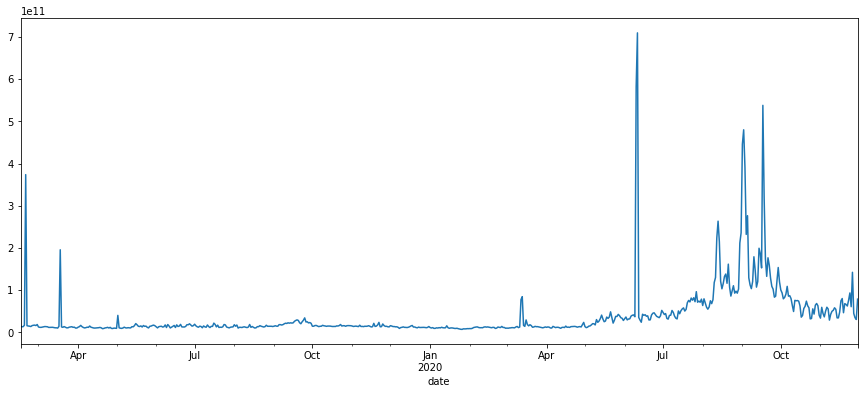

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

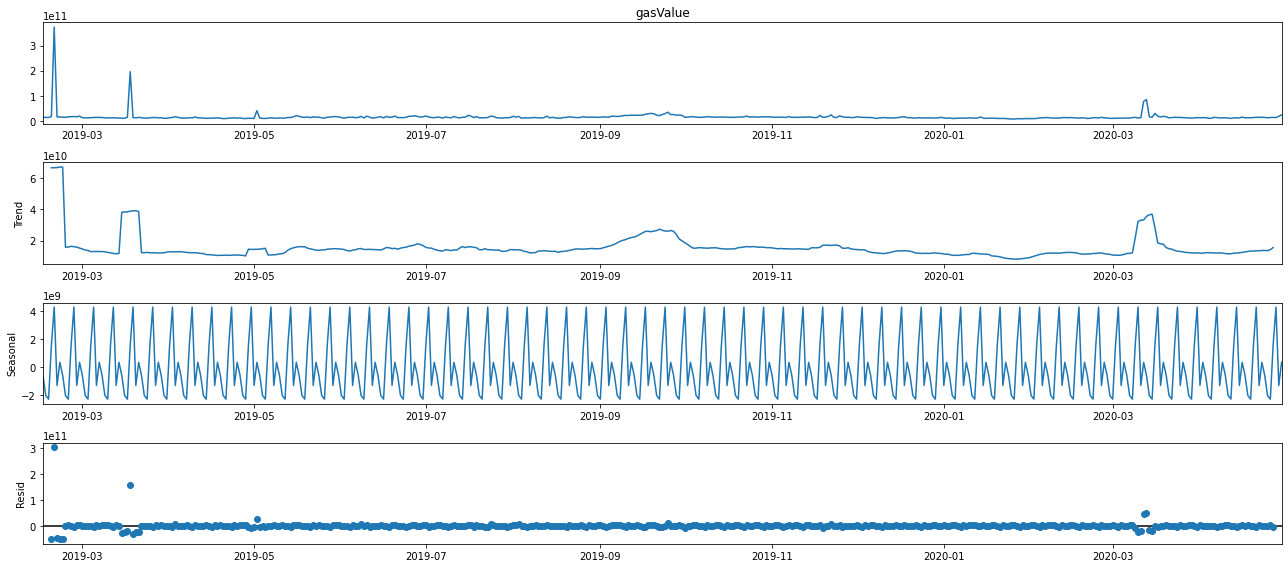

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition.plot()
plt.show()

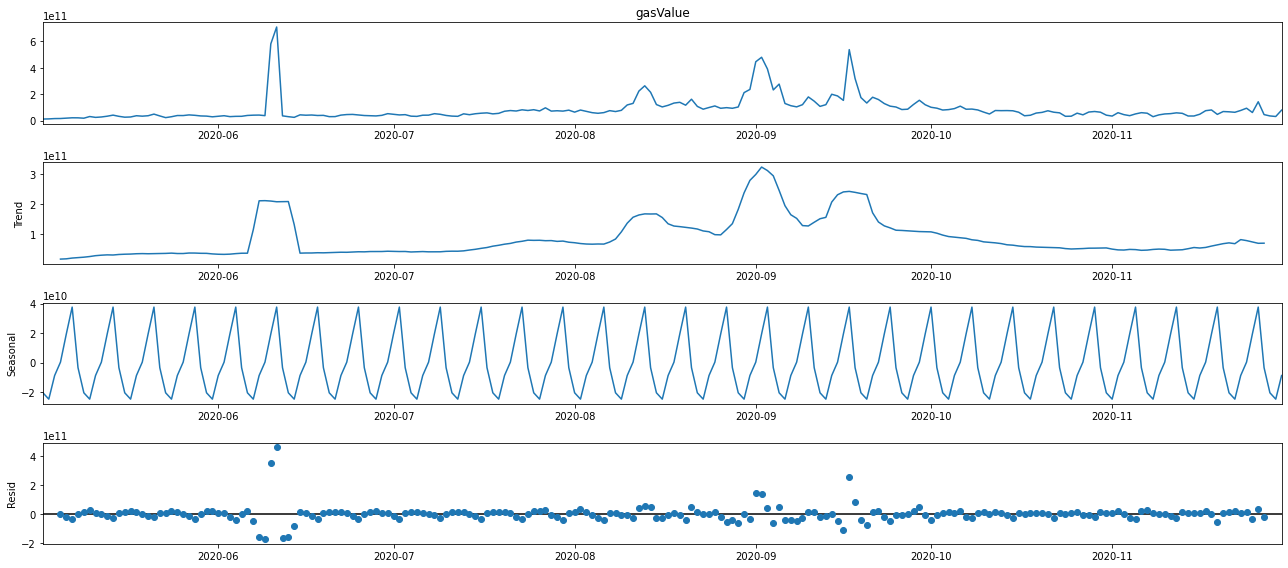

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition.plot()
plt.show()

Let's apply a log transformation to reduce higher gasValue, and also remove the weekly seasonality.

In [12]:
N = 7
gas_slice1['gasValue'] = gas_slice1['gasValue'] - gas_slice1['gasValue'].shift(N)
gas_slice1.dropna(inplace=True)

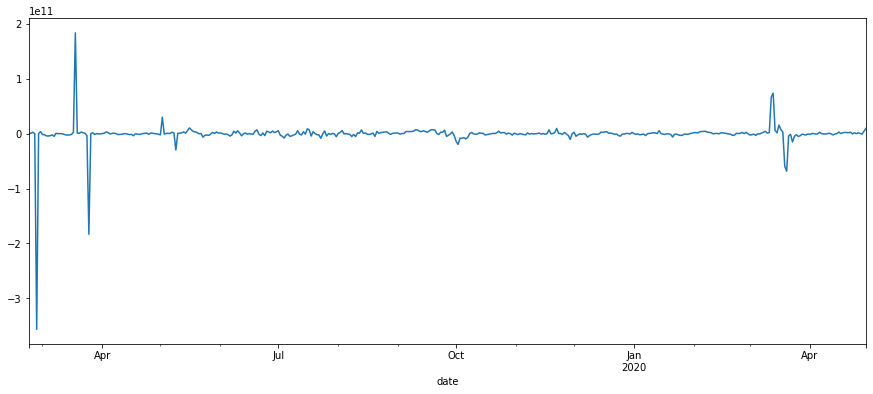

In [13]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [14]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - gas_slice2['gasValue'].shift(N)
gas_slice2.dropna(inplace=True)

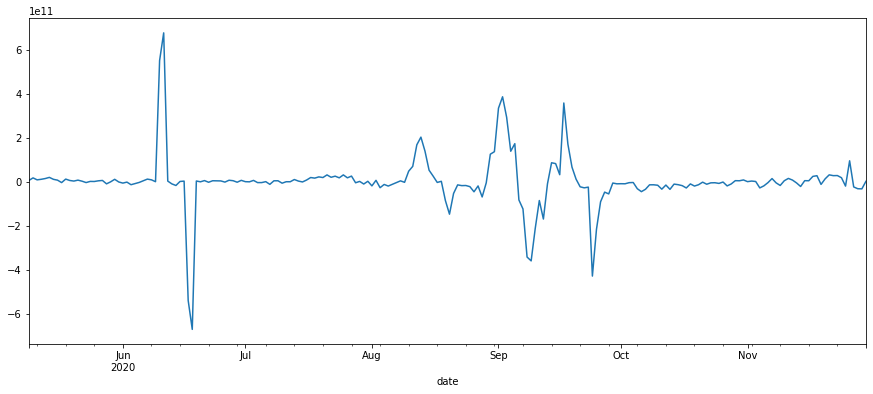

In [15]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [16]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -8.737991e+00
P-Value                 3.063024e-14
# Lags Used             1.300000e+01
# Observations Used     4.200000e+02
Critical Value (1%)    -3.446016e+00
Critical Value (5%)    -2.868446e+00
Critical Value (10%)   -2.570449e+00
dtype: float64


In [17]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.361357
P-Value                   0.000347
# Lags Used              14.000000
# Observations Used     191.000000
Critical Value (1%)      -3.465059
Critical Value (5%)      -2.876794
Critical Value (10%)     -2.574901
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [18]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.18379786739764217
p-value: 0.1
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.04349122192992605
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In both cases, p-gasValue are greater than 0.05, and "KPSS Statistic" gasValue are less than the critical gasValue. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# DAOhaus activity-membership rate series

Let's check the series.

In [20]:
daohaus: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daohaus_activity_membership_rate.csv'), header=0)
daohaus = transform_date_series(df=daohaus, date_key='date')

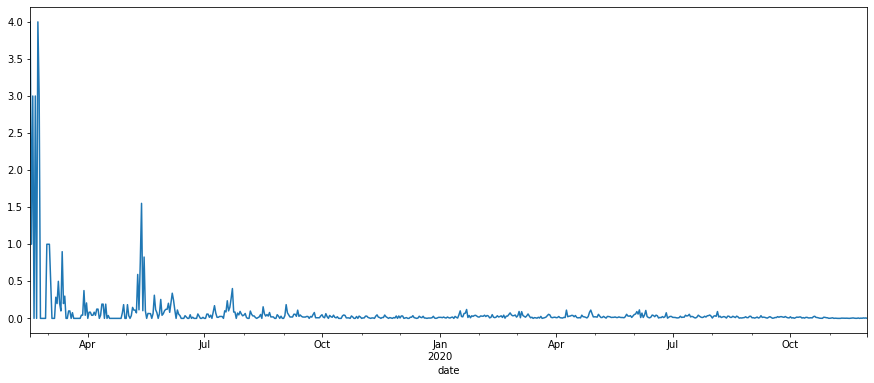

In [21]:
daohaus_plot = filter_series(df=daohaus, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daohaus_plot['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [22]:
daohaus_slice1 = filter_series(df=daohaus, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
daohaus_slice2 = filter_series(df=daohaus, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

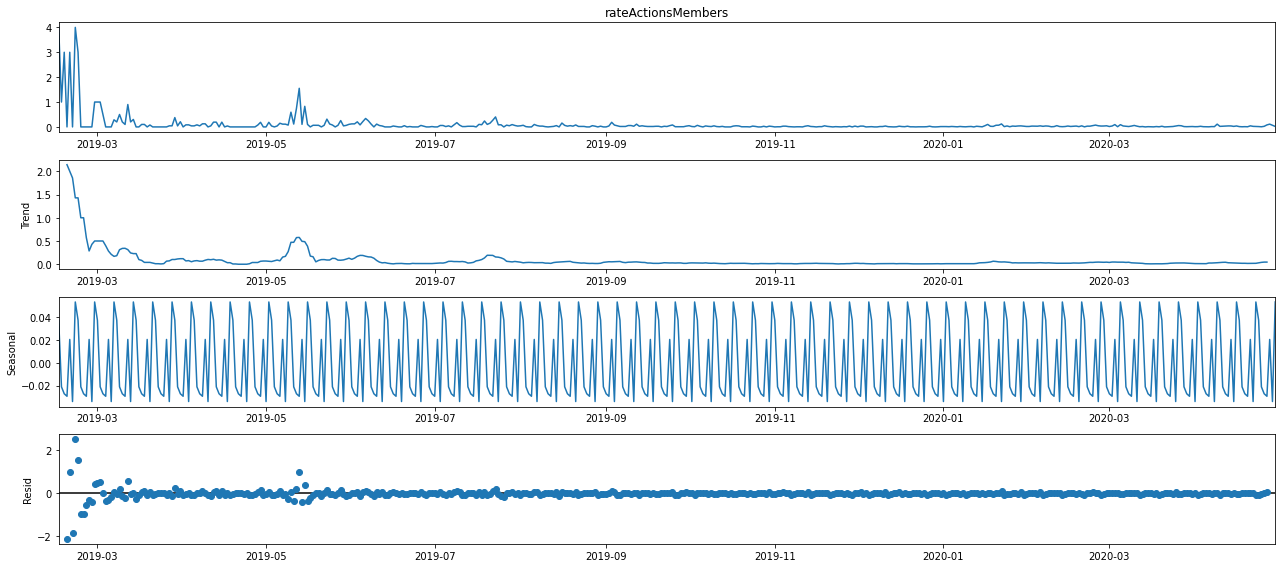

In [23]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=daohaus_slice1['rateActionsMembers'], model='additive')
fig = decomposition.plot()
plt.show()

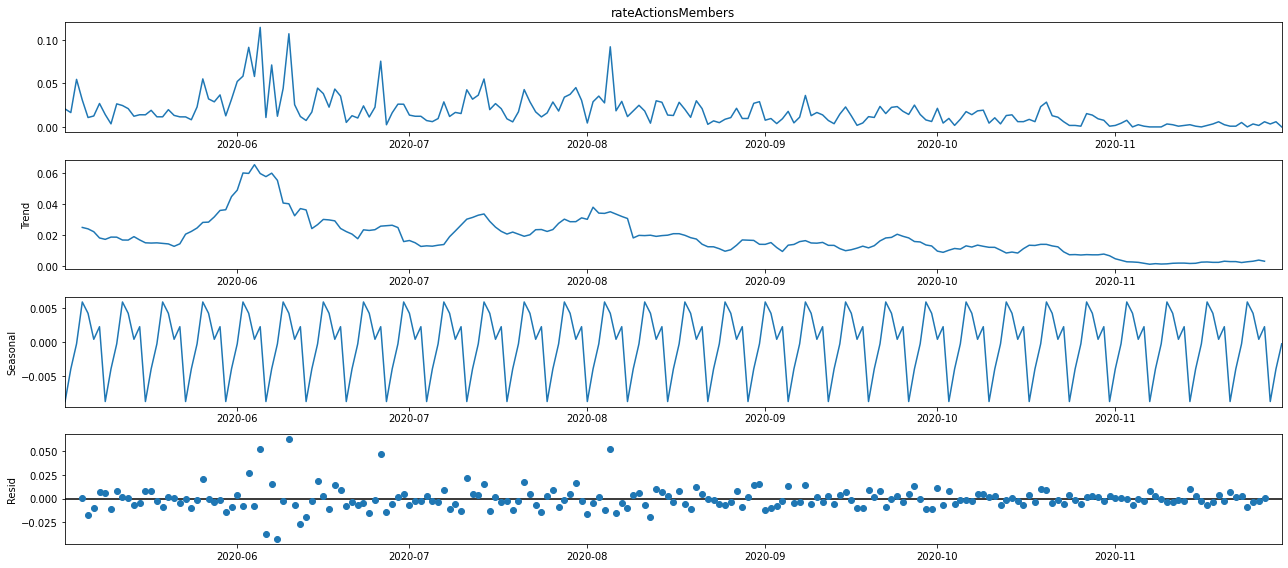

In [24]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=daohaus_slice2['rateActionsMembers'], model='additive')
fig = decomposition.plot()
plt.show()

In [25]:
daohaus_slice1['rateActionsMembers'] = daohaus_slice1['rateActionsMembers'] - daohaus_slice1['rateActionsMembers'].shift(N)
daohaus_slice1.dropna(inplace=True)

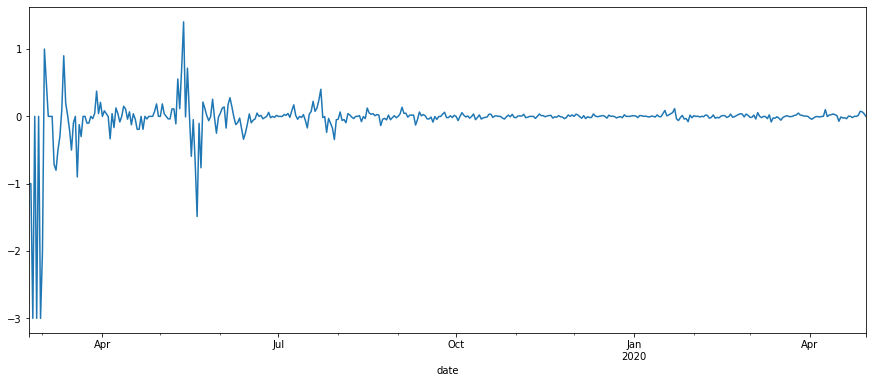

In [26]:
daohaus_slice1['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

In [27]:
daohaus_slice2['rateActionsMembers'] = daohaus_slice2['rateActionsMembers'] - daohaus_slice2['rateActionsMembers'].shift(N)
daohaus_slice2.dropna(inplace=True)

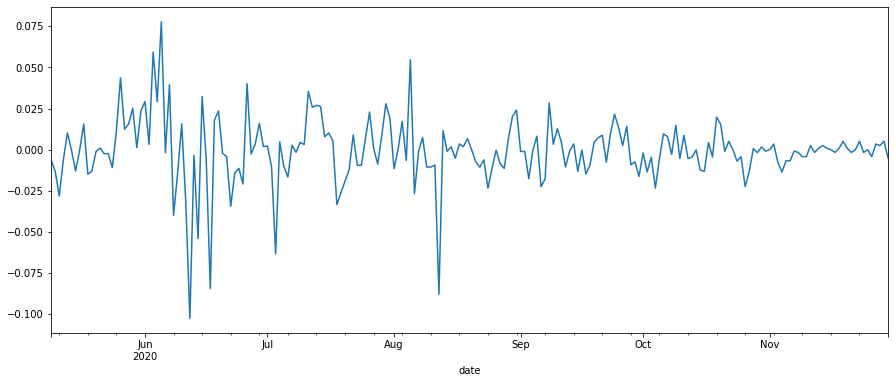

In [28]:
daohaus_slice2['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [29]:
print_adf(df=daohaus_slice1, key='rateActionsMembers')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -5.590799
P-Value                   0.000001
# Lags Used              18.000000
# Observations Used     415.000000
Critical Value (1%)      -3.446206
Critical Value (5%)      -2.868530
Critical Value (10%)     -2.570493
dtype: float64


In [30]:
print_adf(df=daohaus_slice2, key='rateActionsMembers')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.291132
P-Value                   0.000460
# Lags Used              14.000000
# Observations Used     191.000000
Critical Value (1%)      -3.465059
Critical Value (5%)      -2.876794
Critical Value (10%)     -2.574901
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical gasValue. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [31]:
print_kpss(df=daohaus_slice1, key='rateActionsMembers')

KPSS Statistic: 0.5021167375408065
p-value: 0.041189923977295824
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In [32]:
print_kpss(df=daohaus_slice2, key='rateActionsMembers')

KPSS Statistic: 0.035273592724122574
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both series have gasValue that suggest that we fail to reject H0. So, it is definitely a stationary series.

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [33]:
slice1: pd.DataFrame = pd.DataFrame(
    {'daohaus_rate': daohaus_slice1['rateActionsMembers'].tolist(),
     'gasPrice': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.8382 , p=0.0002  , df_denom=430, df_num=1
ssr based chi2 test:   chi2=13.9348 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7152 , p=0.0002  , df=1
parameter F test:         F=13.8382 , p=0.0002  , df_denom=430, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.8774 , p=0.0000  , df_denom=427, df_num=2
ssr based chi2 test:   chi2=44.2671 , p=0.0000  , df=2
likelihood ratio test: chi2=42.1430 , p=0.0000  , df=2
parameter F test:         F=21.8773 , p=0.0000  , df_denom=427, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=24.6867 , p=0.0000  , df_denom=424, df_num=3
ssr based chi2 test:   chi2=75.2829 , p=0.0000  , df=3
likelihood ratio test: chi2=69.3856 , p=0.0000  , df=3
parameter F test:         F=24.6865 , p=0.0000  , df_denom=424, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=46.4376 , p=0.0000  

In [34]:
slice2: pd.DataFrame = pd.DataFrame(
    {'daohaus_rate': daohaus_slice2['rateActionsMembers'].tolist(),
     'gasPrice': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.4694 , p=0.0000  , df_denom=202, df_num=1
ssr based chi2 test:   chi2=18.7437 , p=0.0000  , df=1
likelihood ratio test: chi2=17.9357 , p=0.0000  , df=1
parameter F test:         F=18.4694 , p=0.0000  , df_denom=202, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.4863 , p=0.0000  , df_denom=199, df_num=2
ssr based chi2 test:   chi2=21.4995 , p=0.0000  , df=2
likelihood ratio test: chi2=20.4404 , p=0.0000  , df=2
parameter F test:         F=10.4858 , p=0.0000  , df_denom=199, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.9620  , p=0.0002  , df_denom=196, df_num=3
ssr based chi2 test:   chi2=21.6320 , p=0.0001  , df=3
likelihood ratio test: chi2=20.5553 , p=0.0001  , df=3
parameter F test:         F=6.9564  , p=0.0002  , df_denom=196, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.3362  , p=0.0001  

# VAR analysis

## Slice 1

In [35]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['rateActionsMembers'] = daohaus_slice1['rateActionsMembers'].tolist()

In [36]:
model1 = VAR(slice1)
model1.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,43.25,43.27,6.097e+18,43.26
1,43.09,43.14,5.149e+18,43.11
2,43.05,43.15,4.964e+18,43.09
3,43.06,43.20,5.030e+18,43.12
4,42.92,43.09,4.347e+18,42.98
5,42.93,43.14,4.404e+18,43.01
6,42.85,43.10,4.076e+18,42.95
7,42.49,42.78,2.850e+18,42.61
8,42.48,42.80,2.800e+18,42.61
9,42.49,42.86,2.850e+18,42.64


In [37]:
results1 = model1.fit(maxlags=15, ic='aic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jan, 2021
Time:                     12:46:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    42.8261
Nobs:                     419.000    HQIC:                   42.4648
Log likelihood:          -9973.96    FPE:                2.18713e+18
AIC:                      42.2286    Det(Omega_mle):     1.89617e+18
--------------------------------------------------------------------
Results for equation gasValue
                                coefficient         std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                       11417426.506215   585908158.808606            0.019           0.984
L1.gasValue                        0.091890           0.050588            1.816           0.0

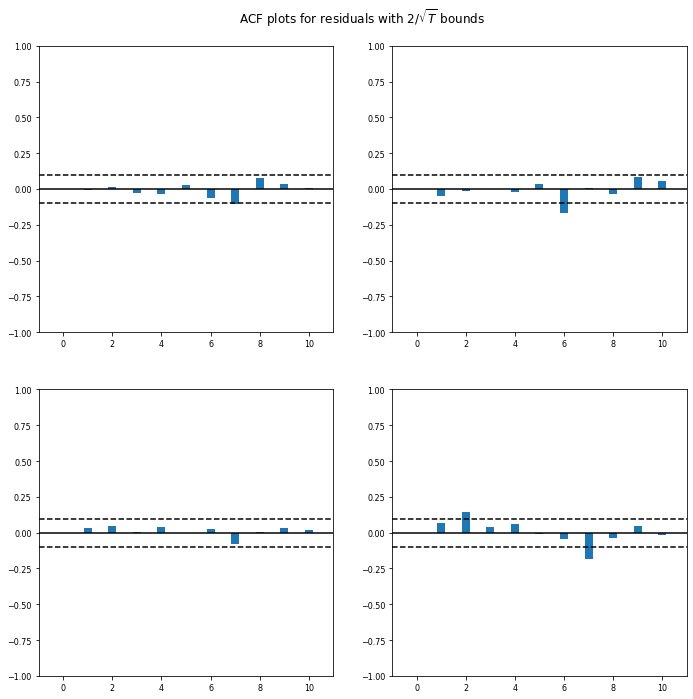

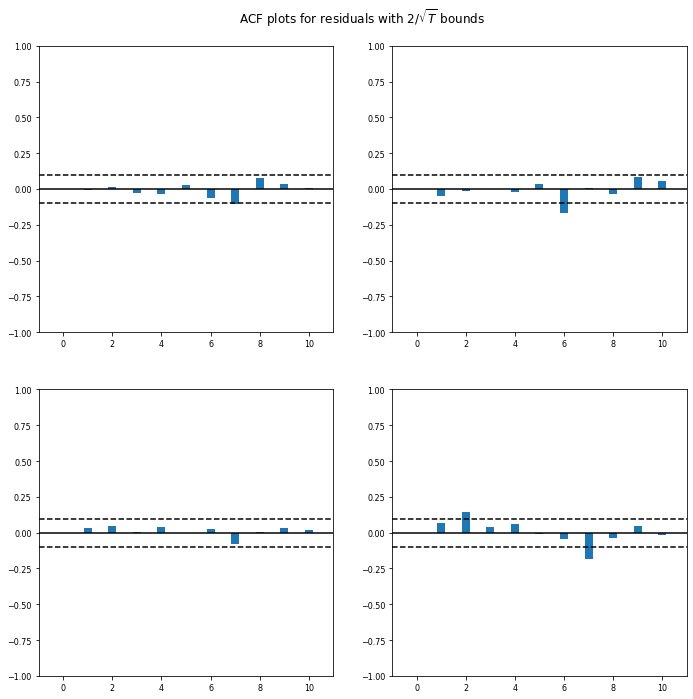

In [38]:
results1.plot_acorr()

### Impulse Response

In [39]:
irf1 = results1.irf(20)

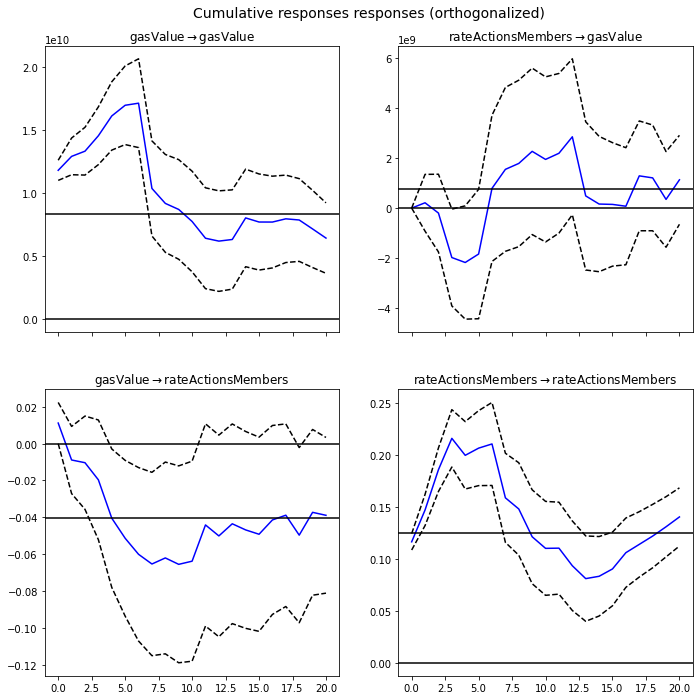

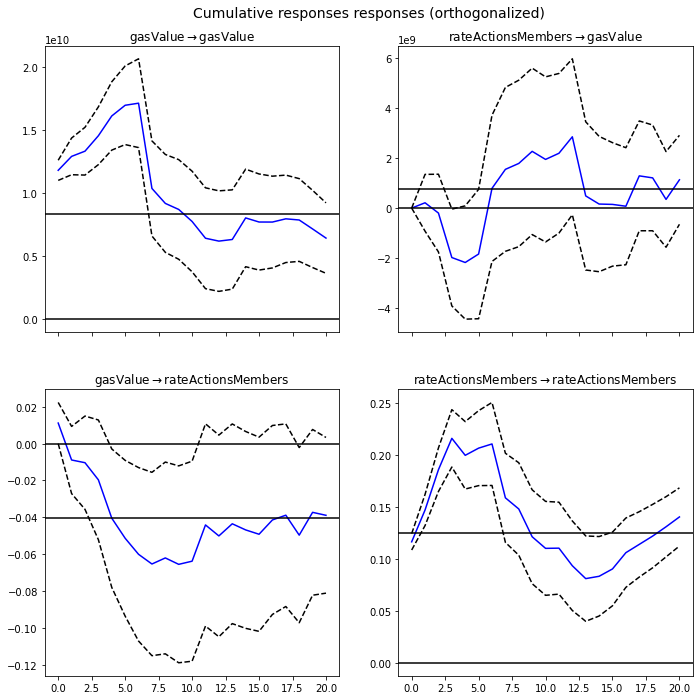

In [40]:
irf1.plot_cum_effects(orth=True)

In [41]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue  rateActionsMembers
0     1.000000            0.000000
1     0.999681            0.000319
2     0.998486            0.001514
3     0.976922            0.023078
4     0.977048            0.022952
5     0.976412            0.023588
6     0.933380            0.066620
7     0.945802            0.054198
8     0.945917            0.054083
9     0.944900            0.055100
10    0.944667            0.055333
11    0.944865            0.055135
12    0.942911            0.057089
13    0.918297            0.081703
14    0.918956            0.081044
15    0.918994            0.081006
16    0.918972            0.081028
17    0.912799            0.087201
18    0.912775            0.087225
19    0.909905            0.090095

FEVD for rateActionsMembers
      gasValue  rateActionsMembers
0     0.009020            0.990980
1     0.034935            0.965065
2     0.031884            0.968116
3     0.034995            0.965005
4     0.057381            0.942619
5     0.

In [42]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
8.853e+04,9.488,0.000,4


In [43]:
results1.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
148.1,31.41,0.000,20


In [44]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
3.746,3.841,0.053,1


## Slice 2

In [45]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['rateActionsMembers'] = daohaus_slice2['rateActionsMembers'].tolist()

In [46]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,43.33,43.36,6.548e+18,43.34
1,42.78,42.88,3.780e+18,42.82
2,42.68,42.85*,3.416e+18,42.74
3,42.67,42.91,3.402e+18,42.77
4,42.66,42.96,3.349e+18,42.78
5,42.64,43.01,3.293e+18,42.79
6,42.54,42.98,2.983e+18,42.72
7,42.36,42.87,2.488e+18,42.56
8,42.28,42.86,2.307e+18,42.52*
9,42.28,42.93,2.316e+18,42.55


In [47]:
results2 = model2.fit(maxlags=2, ic='bic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jan, 2021
Time:                     12:46:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    42.7299
Nobs:                     204.000    HQIC:                   42.6330
Log likelihood:          -4910.78    FPE:                3.06707e+18
AIC:                      42.5672    Det(Omega_mle):     2.92207e+18
--------------------------------------------------------------------
Results for equation gasValue
                                 coefficient           std. error           t-stat            prob
--------------------------------------------------------------------------------------------------
const                       319538792.028237    6461513261.017995            0.049           0.961
L1.gasValue                         0.727239             0.068966           10.545  

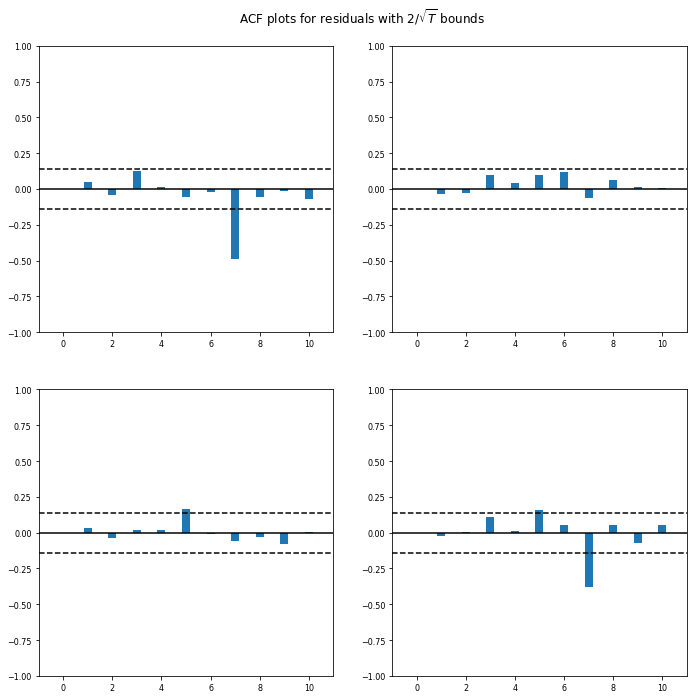

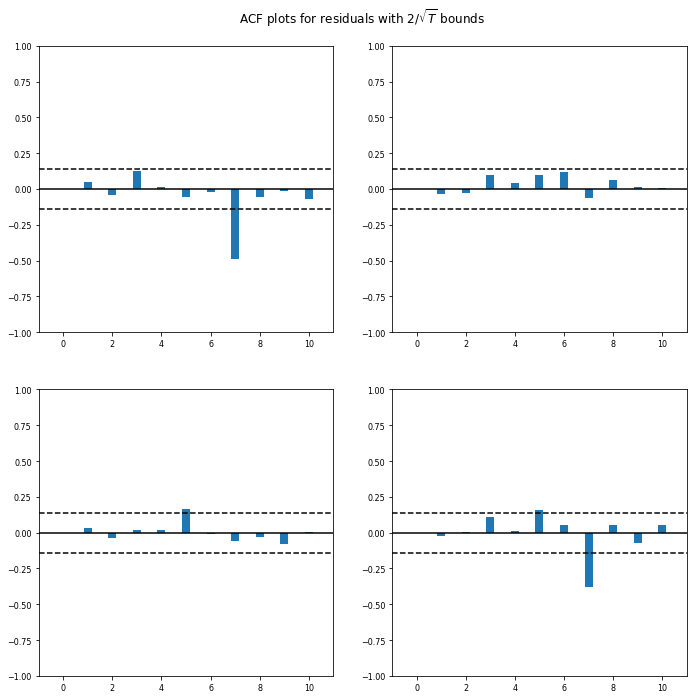

In [48]:
results2.plot_acorr()

### Impulse Response

In [49]:
irf2 = results2.irf(20)

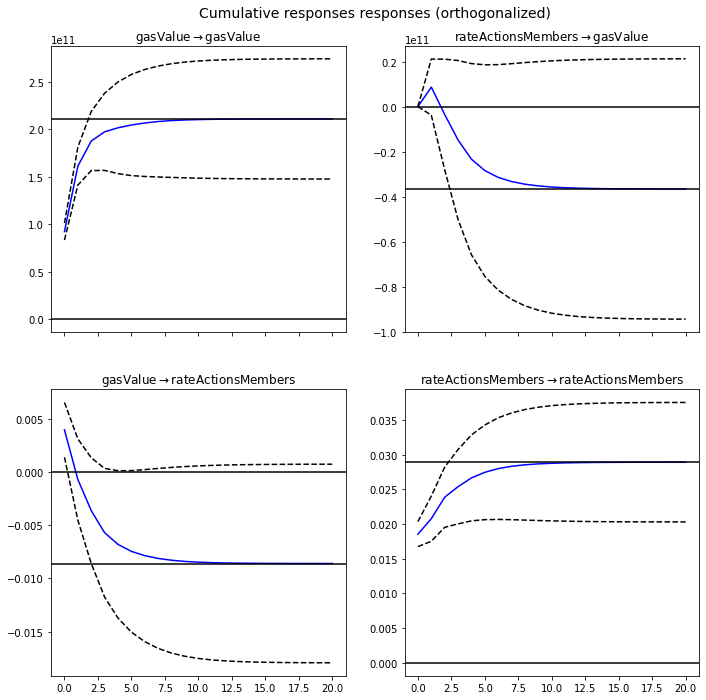

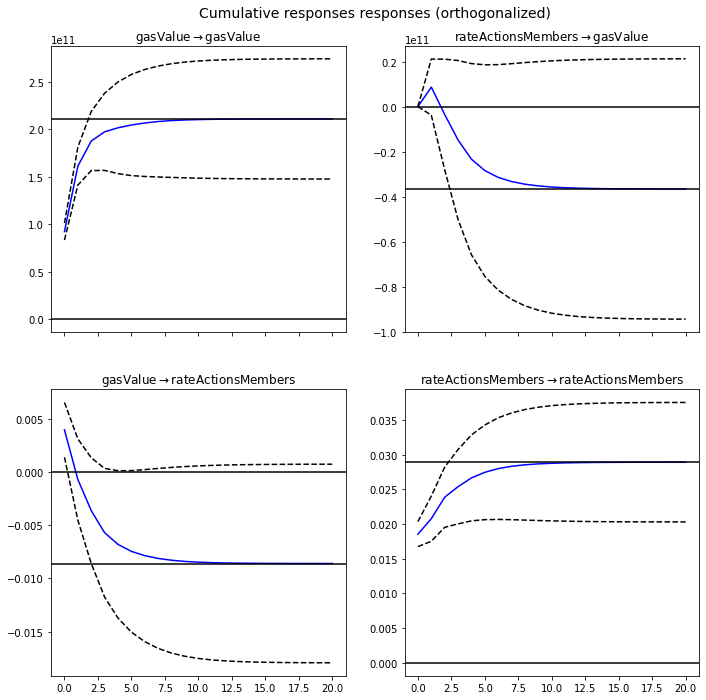

In [50]:
irf2.plot_cum_effects(orth=True)

In [51]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue  rateActionsMembers
0     1.000000            0.000000
1     0.994391            0.005609
2     0.984288            0.015712
3     0.975547            0.024453
4     0.970688            0.029312
5     0.968993            0.031007
6     0.968391            0.031609
7     0.968169            0.031831
8     0.968079            0.031921
9     0.968042            0.031958
10    0.968026            0.031974
11    0.968019            0.031981
12    0.968017            0.031983
13    0.968016            0.031984
14    0.968015            0.031985
15    0.968015            0.031985
16    0.968015            0.031985
17    0.968015            0.031985
18    0.968015            0.031985
19    0.968015            0.031985

FEVD for rateActionsMembers
      gasValue  rateActionsMembers
0     0.043776            0.956224
1     0.097174            0.902826
2     0.113997            0.886003
3     0.122683            0.877317
4     0.124748            0.875252
5     0.

In [52]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
1719.,9.488,0.000,4


In [53]:
results2.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
161.9,92.81,0.000,72


In [54]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
8.556,3.841,0.003,1


# SARIMAX

In [55]:
def get2d_array(array: List[float]) -> List[List[float]]:
    array2d: List[List[float]] = []
        
    for x in array:
        array2d.append([x])
    
    return array2d

## Slice1

In [56]:
# fitting a stepwise model:
stepwise_fit = pm.auto_arima(y=slice1['rateActionsMembers'], X=get2d_array(slice1['gasValue']),
                             start_p=1, start_q=1, max_p=3, max_q=3, start_P=0,
                             m=7, # The period for seasonal differencing
                             seasonal=True, d=0, D=0, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=225.314, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=218.320, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=162.664, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=254.073, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2423.054, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=166.101, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=165.368, Time=0.41 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=200.362, Time=0.34 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=202.744, Time=0.43 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=202.326, Time=0.75 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=214.557, Time=0.16 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=150.179, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=156.241, Time=0.13 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=148.093, Time=0.55 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=180.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  434
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 7)   Log Likelihood                 -67.872
Date:                           Tue, 05 Jan 2021   AIC                            147.743
Time:                                   12:46:30   BIC                            172.182
Sample:                                        0   HQIC                           157.390
                                           - 434                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.848e-12   2.24e-13     21.619      0.000    4.41e-12    5.29e-12
ar.L1          0.2693   1.11e-25   2.42e+24      0.000       0.269       0.269
ar.L2          0.1685   2.56e-26   6.59e+24      0.000       0.169       0.169
ar.S.L7       -0.2632   3.16e-25  -8.33e+23      0.000      -0.263      -0.263
ar.S.L14       0.0086    1.6e-25   5.35e+22      0.000       0.009       0.009
sigma2         0.0795    1.5e-23   5.31e+21      0.000       0.080       0.080
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             33416.40
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            -3.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

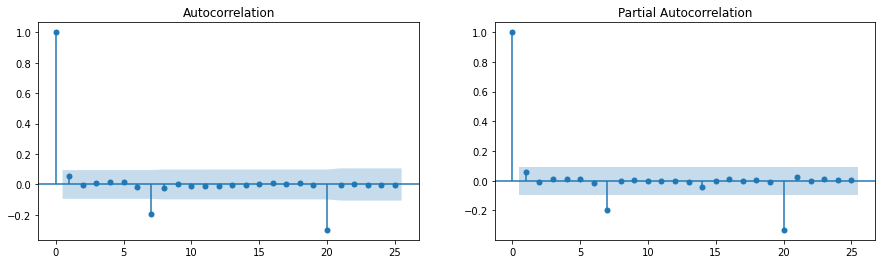

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(slice1.iloc[1:]['gasValue'], lags=25, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(slice1.iloc[1:]['gasValue'], lags=25, ax=axes[1])

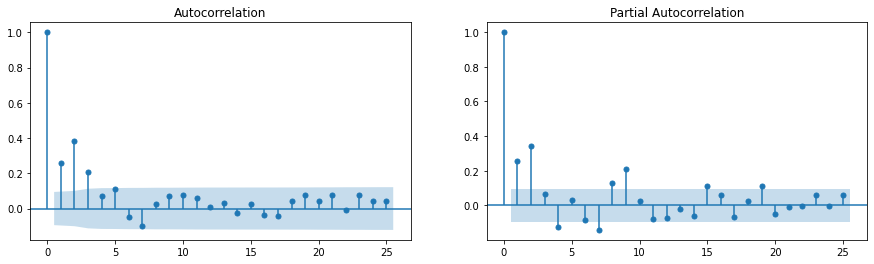

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(slice1.iloc[1:]['rateActionsMembers'], lags=25, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(slice1.iloc[1:]['rateActionsMembers'], lags=25, ax=axes[1])

In [59]:
mod1 = sm.tsa.statespace.SARIMAX(
    endog=slice1['rateActionsMembers'], 
    exog=slice1['gasValue'], 
    #trend='c', 
    order=(2,0,0), 
    seasonal_order=(2,0,0,7))

res1 = mod1.fit(disp=False)
print(res1.summary())

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                rateActionsMembers   No. Observations:                  434
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 7)   Log Likelihood                 -67.872
Date:                           Tue, 05 Jan 2021   AIC                            147.743
Time:                                   12:46:31   BIC                            172.182
Sample:                               02-22-2019   HQIC                           157.390
                                    - 04-30-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gasValue    4.848e-12   2.24e-13     21.619      0.000    4.41e-12    5.29e-12
ar.L1          0.2693   1.11e-25   2.42e+24

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
